<a href="https://colab.research.google.com/github.com/ChristophWuersch/AppliedNeuralNetworks/blob/main/exercises/U01/t81_558_class_03_1_neural_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="Bilder/ost_logo.png" width="240" height="240" align="right"/>
<div style="text-align: left"> <b> Applied Neural Networks | FS 2022 </b><br>
<a href="mailto:christoph.wuersch@ost.ch"> © Christoph Würsch </a> </div>
<a href="https://www.ost.ch/de/forschung-und-dienstleistungen/technik/systemtechnik/ice-institut-fuer-computational-engineering/"> Eastern Switzerland University of Applied Sciences OST | ICE </a>


## Ein erstes Neuronales Netz mit `keras`: Pima Indians

## (a) Datensatz laden

In [23]:
# first neural network with keras tutorial
import tensorflow as tf
import numpy as np
from numpy import loadtxt

import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


import matplotlib.pyplot as plt


In [2]:
# load the dataset
# dataset = loadtxt('pima-indians-diabetes.csv', delimiter=',')
# split into input (X) and output (y) variables
df=pd.read_csv('diabetes.csv', delimiter=',')
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## (b) Kurze EDA

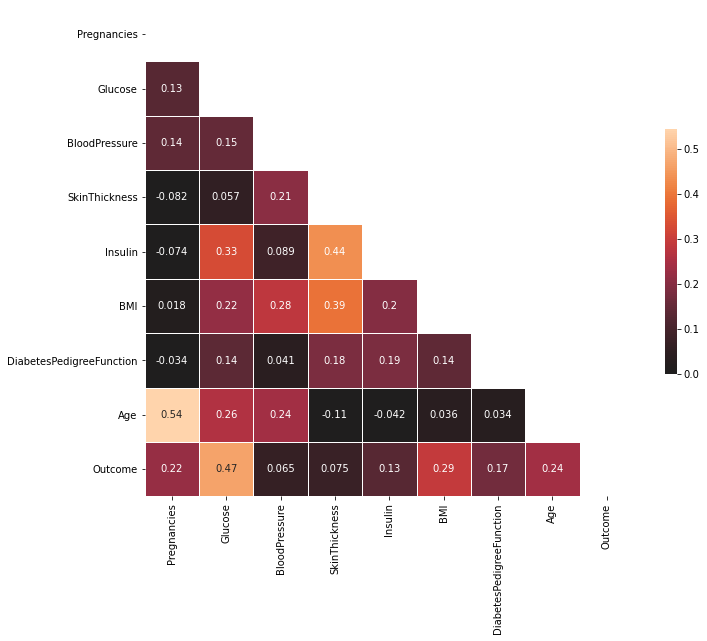

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin=0.0, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.show()


In [3]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
X = df.iloc[:,0:8].values
y = df.iloc[:,8].values


## (c) Modell erstellen

In [5]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

## (d) Modell darstellen

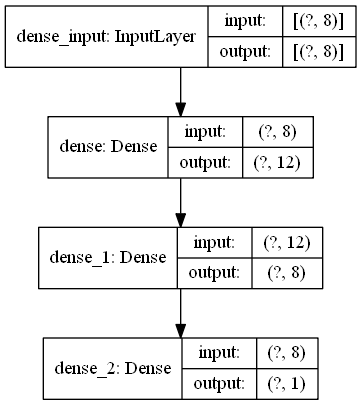

In [6]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## (e) Modell kompilieren und trainieren

In [7]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [29]:
# fit the keras model on the dataset
model.fit(X, y, epochs=100, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/100
77/77 [==============================] - 0s 571us/step - loss: 0.6082 - accuracy: 0.6888
Epoch 2/100
77/77 [==============================] - 0s 583us/step - loss: 0.6515 - accuracy: 0.6940
Epoch 3/100
77/77 [==============================] - 0s 570us/step - loss: 0.6263 - accuracy: 0.6823
Epoch 4/100
77/77 [==============================] - 0s 571us/step - loss: 0.6066 - accuracy: 0.7070
Epoch 5/100
77/77 [==============================] - 0s 571us/step - loss: 0.5965 - accuracy: 0.7188
Epoch 6/100
77/77 [==============================] - 0s 571us/step - loss: 0.6040 - accuracy: 0.6940
Epoch 7/100
77/77 [==============================] - 0s 583us/step - loss: 0.5870 - accuracy: 0.7057
Epoch 8/100
77/77 [==============================] - 0s 584us/step - loss: 0.6184 - accuracy: 0.6992
Epoch 9/100
77/77 [==============================] - 0s 571us/step - loss: 0.6194 - accuracy: 0.6927
Epoch 10/100
77/77 [==============================] - 0s 571us/step - loss: 0.6019 - accura

## (f) Modell abspeichern

In [9]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


Sie können Ihr Modell speichern, indem Sie die Funktion `save()` für das Modell aufrufen und den Dateinamen angeben.
Das folgende Beispiel demonstriert dies, indem zunächst ein Modell angepasst, ausgewertet und in der Datei "model.h5" gespeichert wird.

In [10]:
# save model and architecture to single file
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


## (g) Modell laden

In [11]:
# load and evaluate a saved model

from keras.models import load_model
from keras.models import model_from_json

# load model
model = load_model('model.h5')
# summarize model.
model.summary()

# load dataset
dataset = loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

# evaluate the model
score = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                108       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
accuracy: 74.48%
Loaded model from disk


## (h) Aufteilen in einen Trainings und Validierungsdatensatz

Teilen Sie den geladenen Datensatz in einen Trainings- und einen Testdatensatz auf (Aufteilung nach Zeilen) und verwenden Sie einen die Trainingsdaten (80%), um das Modell zu trainieren, und den Validierungsdatensatz (20%), um die Leistung des Modells auf neuen Daten zu schätzen.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

val_dataframe   = df.sample(frac=0.2, random_state=1337)
train_dataframe = df.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)


Using 614 samples for training and 154 for validation


## (i) Dataset-Objekt erstellen

Die `tf.data`-API (\url{https://www.tensorflow.org/guide/data}) ermöglicht es Ihnen, komplexe Eingangs-Pipelines aus einfachen, wiederverwendbaren Teilen aufzubauen. Die Pipeline für ein Bildmodell könnte beispielsweise Daten aus Dateien in einem verteilten Dateisystem aggregieren, zufällige Störungen auf jedes Bild anwenden und zufällig ausgewählte Bilder zum Training zu einem Stapel (batch) zusammenführen. Die Pipeline für Texdaten kann das Extrahieren von Symbolen aus Rohtextdaten, deren Umwandlung in ein Embeddding und das Zusammenführen von Sequenzen unterschiedlicher Länge umfassen. Die `tf.data` API ermöglicht es , grosse Datenmengen zu verarbeiten, liest aus verschiedenen Datenformaten und ist in der Lage, komplexe Transformationen durchzuführen.
		
Die `tf.data`-API führt ein \texttt{tf.data.Dataset}-Objekt ein, welches eine Sequenz von Elementen darstellt, wobei jedes Element aus einer oder mehreren Komponenten besteht. In einer Bild-Pipeline könnte ein Element zum Beispiel ein einzelnes Trainingsbeispiel sein, bestehend aus einem Tupel aus je zwei Tensoren, die das Bild und sein Label darstellen.


In [30]:
def dataframe_to_dataset(df):
    dg = df.copy()
    labels = dg.pop('Outcome')
    dataset = tf.data.Dataset.from_tensor_slices((dg.values, labels.values))
    dataset = dataset.batch(32).repeat()
    dataset = dataset.shuffle(buffer_size=len(df))
    return dataset

In [17]:
train_dataset=dataframe_to_dataset(train_dataframe)
val_dataset  =dataframe_to_dataset(val_dataframe)

## (j) Lernkurven grafisch darstellen

Die Funktion `fit()` gibt ein `History`-Objekt zurück, das den Verlust und die Genauigkeit am Ende jeder Epoche zusammenfasst. Erstellen Sie Liniendiagramme dieser Daten, sogenannte Lernkurven.


In [18]:
def plot_history(history):
    #print(history.history.keys())
    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True); plt.show()
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True); plt.show()

In [19]:
history=model.fit(train_dataset, epochs=50, 
          steps_per_epoch=100,
          validation_data=val_dataset,
          validation_steps=10)

print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/50
100/100 [==============================] - 0s 1ms/step - loss: 0.4797 - accuracy: 0.7719 - val_loss: 0.4848 - val_accuracy: 0.7890
Epoch 2/50
100/100 [==============================] - 0s 527us/step - loss: 0.4592 - accuracy: 0.7925 - val_loss: 0.4955 - val_accuracy: 0.7420
Epoch 3/50
100/100 [==============================] - 0s 499us/step - loss: 0.4745 - accuracy: 0.7684 - val_loss: 0.4891 - val_accuracy: 0.7417
Epoch 4/50
100/100 [==============================] - 0s 499us/step - loss: 0.4661 - accuracy: 0.7831 - val_loss: 0.4805 - val_accuracy: 0.7848
Epoch 5/50
100/100 [==============================] - 0s 489us/step - loss: 0.4611 - accuracy: 0.7759 - val_loss: 0.5522 - val_accuracy: 0.7103
Epoch 6/50
100/100 [==============================] - 0s 500us/step - loss: 0.4655 - accuracy: 0.7793 - val_loss: 0.4765 - val_accuracy: 0.7848
Epoch 7/50
100/100 [==============================] - 0s 499us/step - loss: 0.4664 - accuracy: 0.7730 - val_loss: 0.4720 - val_accuracy: 0

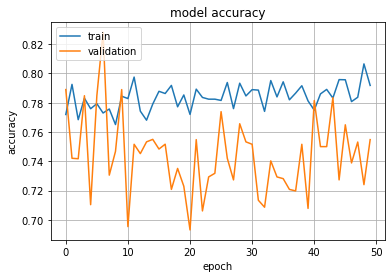

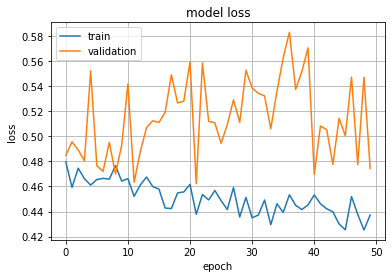

In [20]:
plot_history(history)

In [24]:
# define the keras model
model = Sequential()
model.add(Dense(16, input_dim=8, activation='relu'))
model.add(Dropout(0.40))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history=model.fit(train_dataset, epochs=50, 
          steps_per_epoch=100,
          validation_data=val_dataset,
          validation_steps=10)

print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/50
100/100 [==============================] - 0s 1ms/step - loss: 2.1636 - accuracy: 0.5115 - val_loss: 0.7239 - val_accuracy: 0.5892
Epoch 2/50
100/100 [==============================] - 0s 523us/step - loss: 1.1871 - accuracy: 0.5575 - val_loss: 0.6656 - val_accuracy: 0.6656
Epoch 3/50
100/100 [==============================] - 0s 509us/step - loss: 0.9111 - accuracy: 0.5733 - val_loss: 0.6716 - val_accuracy: 0.6351
Epoch 4/50
100/100 [==============================] - 0s 508us/step - loss: 0.8342 - accuracy: 0.5948 - val_loss: 0.6254 - val_accuracy: 0.7417
Epoch 5/50
100/100 [==============================] - 0s 509us/step - loss: 0.7790 - accuracy: 0.6055 - val_loss: 0.6805 - val_accuracy: 0.6126
Epoch 6/50
100/100 [==============================] - 0s 509us/step - loss: 0.7399 - accuracy: 0.6235 - val_loss: 0.6370 - val_accuracy: 0.7240
Epoch 7/50
100/100 [==============================] - 0s 496us/step - loss: 0.7119 - accuracy: 0.6283 - val_loss: 0.6394 - val_accuracy: 0

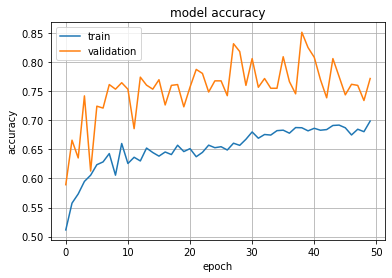

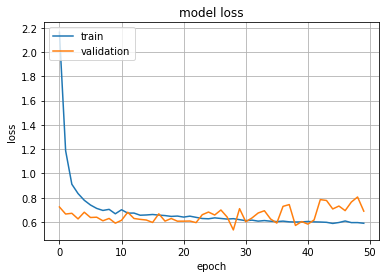

In [27]:
plot_history(history)

## (l) Trainieren auf einem neuen Datensatzes

Probieren Sie, einen anderen Tabellendatensatz zu verwenden, vielleicht aus dem UCI Machine Learning Repository.

## (k)  Das Modell anpassen

Ändern Sie die Konfiguration des Modells oder den Trainingsprozess und sehen Sie, ob Sie die Leistung des Modells verbessern können, z. B. eine Genauigkeit von mehr als 76 % erreichen.
